# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
learning_rates = [7e-7, 1e-6, 4e-6, 1e-5, 5e-5, 1e-4, 4e-4]
regularization_strengths = [1e-1, 5e-1, 1e0, 5e0, 1e1, 5e1, 1e2, 5e2, 8e2, 1e3, 2e3, 3e3, 6e3, 8e3]
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                              num_iters=1200, verbose=True) 
        y_train_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        valid_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, valid_accuracy)
        if valid_accuracy > best_val:
            best_val = valid_accuracy
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1200: loss 8.982930
iteration 100 / 1200: loss 8.974272
iteration 200 / 1200: loss 8.960515
iteration 300 / 1200: loss 8.963180
iteration 400 / 1200: loss 8.966612
iteration 500 / 1200: loss 8.956445
iteration 600 / 1200: loss 8.952833
iteration 700 / 1200: loss 8.939558
iteration 800 / 1200: loss 8.936457
iteration 900 / 1200: loss 8.931224
iteration 1000 / 1200: loss 8.927287
iteration 1100 / 1200: loss 8.921354
iteration 0 / 1200: loss 8.993542
iteration 100 / 1200: loss 8.987481
iteration 200 / 1200: loss 8.997254
iteration 300 / 1200: loss 8.995885
iteration 400 / 1200: loss 8.972827
iteration 500 / 1200: loss 8.966700
iteration 600 / 1200: loss 8.967450
iteration 700 / 1200: loss 8.971340
iteration 800 / 1200: loss 8.966385
iteration 900 / 1200: loss 8.976192
iteration 1000 / 1200: loss 8.949212
iteration 1100 / 1200: loss 8.944079
iteration 0 / 1200: loss 8.994141
iteration 100 / 1200: loss 8.986735
iteration 200 / 1200: loss 8.992213
iteration 300 / 1200: loss 8.9

iteration 100 / 1200: loss 9.085606
iteration 200 / 1200: loss 9.048523
iteration 300 / 1200: loss 9.055605
iteration 400 / 1200: loss 9.042398
iteration 500 / 1200: loss 9.029946
iteration 600 / 1200: loss 9.011591
iteration 700 / 1200: loss 9.021010
iteration 800 / 1200: loss 9.014291
iteration 900 / 1200: loss 9.019050
iteration 1000 / 1200: loss 8.999220
iteration 1100 / 1200: loss 8.976780
iteration 0 / 1200: loss 9.169658
iteration 100 / 1200: loss 9.146751
iteration 200 / 1200: loss 9.153618
iteration 300 / 1200: loss 9.120917
iteration 400 / 1200: loss 9.108431
iteration 500 / 1200: loss 9.102664
iteration 600 / 1200: loss 9.079131
iteration 700 / 1200: loss 9.083005
iteration 800 / 1200: loss 9.065842
iteration 900 / 1200: loss 9.050747
iteration 1000 / 1200: loss 9.050409
iteration 1100 / 1200: loss 9.042240
iteration 0 / 1200: loss 9.751248
iteration 100 / 1200: loss 9.616520
iteration 200 / 1200: loss 9.501795
iteration 300 / 1200: loss 9.412648
iteration 400 / 1200: loss 9

iteration 100 / 1200: loss 9.114107
iteration 200 / 1200: loss 8.994448
iteration 300 / 1200: loss 8.991319
iteration 400 / 1200: loss 8.991326
iteration 500 / 1200: loss 8.992296
iteration 600 / 1200: loss 8.990857
iteration 700 / 1200: loss 8.989890
iteration 800 / 1200: loss 8.992795
iteration 900 / 1200: loss 8.988534
iteration 1000 / 1200: loss 8.991079
iteration 1100 / 1200: loss 8.990814
iteration 0 / 1200: loss 13.829878
iteration 100 / 1200: loss 9.032229
iteration 200 / 1200: loss 8.995457
iteration 300 / 1200: loss 8.994816
iteration 400 / 1200: loss 8.994426
iteration 500 / 1200: loss 8.994512
iteration 600 / 1200: loss 8.993470
iteration 700 / 1200: loss 8.993904
iteration 800 / 1200: loss 8.994403
iteration 900 / 1200: loss 8.993902
iteration 1000 / 1200: loss 8.994656
iteration 1100 / 1200: loss 8.995177
iteration 0 / 1200: loss 18.209210
iteration 100 / 1200: loss 8.997756
iteration 200 / 1200: loss 8.997800
iteration 300 / 1200: loss 8.996840
iteration 400 / 1200: loss

iteration 100 / 1200: loss 8.667591
iteration 200 / 1200: loss 8.382670
iteration 300 / 1200: loss 7.925821
iteration 400 / 1200: loss 7.649065
iteration 500 / 1200: loss 7.325666
iteration 600 / 1200: loss 6.850551
iteration 700 / 1200: loss 6.821477
iteration 800 / 1200: loss 6.493722
iteration 900 / 1200: loss 6.257530
iteration 1000 / 1200: loss 6.174369
iteration 1100 / 1200: loss 5.516474
iteration 0 / 1200: loss 9.008710
iteration 100 / 1200: loss 8.644116
iteration 200 / 1200: loss 8.232100
iteration 300 / 1200: loss 7.897735
iteration 400 / 1200: loss 7.611221
iteration 500 / 1200: loss 7.600640
iteration 600 / 1200: loss 6.960872
iteration 700 / 1200: loss 6.726164
iteration 800 / 1200: loss 6.165433
iteration 900 / 1200: loss 6.321732
iteration 1000 / 1200: loss 6.144428
iteration 1100 / 1200: loss 6.071851
iteration 0 / 1200: loss 9.013627
iteration 100 / 1200: loss 8.643057
iteration 200 / 1200: loss 8.338791
iteration 300 / 1200: loss 8.106156
iteration 400 / 1200: loss 7

iteration 100 / 1200: loss 8.841299
iteration 200 / 1200: loss 8.810360
iteration 300 / 1200: loss 8.838939
iteration 400 / 1200: loss 8.813361
iteration 500 / 1200: loss 8.847003
iteration 600 / 1200: loss 8.855743
iteration 700 / 1200: loss 8.860133
iteration 800 / 1200: loss 8.793467
iteration 900 / 1200: loss 8.833902
iteration 1000 / 1200: loss 8.824006
iteration 1100 / 1200: loss 8.824655
iteration 0 / 1200: loss 9.761118
iteration 100 / 1200: loss 8.969237
iteration 200 / 1200: loss 8.969332
iteration 300 / 1200: loss 8.970438
iteration 400 / 1200: loss 8.970569
iteration 500 / 1200: loss 8.964258
iteration 600 / 1200: loss 8.964215
iteration 700 / 1200: loss 8.963047
iteration 800 / 1200: loss 8.959340
iteration 900 / 1200: loss 8.959564
iteration 1000 / 1200: loss 8.967004
iteration 1100 / 1200: loss 8.966697
iteration 0 / 1200: loss 10.123969
iteration 100 / 1200: loss 8.984336
iteration 200 / 1200: loss 8.977053
iteration 300 / 1200: loss 8.976128
iteration 400 / 1200: loss 

iteration 100 / 1200: loss 795804113403110997236908032000.000000
iteration 200 / 1200: loss 133786815140967942342436134294192446027051607530928749936640.000000
iteration 300 / 1200: loss 22491605162760594004214098873906371010194212049619982559542000234388908572051737331892224.000000
iteration 400 / 1200: loss 3781182041477654784108860624093250576245653542756771248518169869467568073054934488912395886246293685425745320048852992.000000
iteration 500 / 1200: loss 635674400618826018723931525155431198662768412888101501652289160270041819980898846189957653844278881378245262818559358342533848760385693887024332800.000000
iteration 600 / 1200: loss 106866566901442169697781295539343611107865213045314336660054812951074656323552678973123536000816226528025076926177363230196721288538654559664906301084806274053357418312672215040.000000
iteration 700 / 1200: loss 1796590064061515209778128212425931211397405852788043149591466012908950712361599986644134429283821978510597174346314786487609191363752021368903

/home/jupyter/cs231n/assignment1/cs231n/classifiers/linear_svm.py:85: RuntimeWarning: overflow encountered in double_scalars
  loss = np.sum(margin) / X.shape[0] + reg*np.sum(W*W)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/jupyter/cs231n/assignment1/cs231n/classifiers/linear_svm.py:85: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(margin) / X.shape[0] + reg*np.sum(W*W)


iteration 1100 / 1200: loss inf
iteration 0 / 1200: loss 18.222030
iteration 100 / 1200: loss 835502036362036576083852167342107399217049840234016374006732939276161184386957699316011593938534504289313609842950144.000000
iteration 200 / 1200: loss 75625252220657413234428036152209133286391930779784474640230239930668174759877618981324950820900238597632838456407748631205646321260704015565210616404370936393183506984505197815606457993983867613913836167875011152801855849931533713408.000000
iteration 300 / 1200: loss inf
iteration 400 / 1200: loss inf
iteration 500 / 1200: loss inf
iteration 600 / 1200: loss nan


/home/jupyter/cs231n/assignment1/cs231n/classifiers/linear_svm.py:104: RuntimeWarning: overflow encountered in multiply
  dW += 2*reg*W
/home/jupyter/cs231n/assignment1/cs231n/classifiers/linear_svm.py:83: RuntimeWarning: invalid value encountered in subtract
  margin = np.clip(scores - true_class_scores.reshape(true_class_scores.shape[0], 1) + 1, a_min = 0, a_max = None)
/home/jupyter/cs231n/assignment1/cs231n/classifiers/linear_svm.py:100: RuntimeWarning: invalid value encountered in greater
  dw_margin = np.asarray((margin > 0), dtype=int)
/home/jupyter/cs231n/assignment1/cs231n/classifiers/linear_classifier.py:70: RuntimeWarning: invalid value encountered in add
  self.W += - learning_rate * grad


iteration 700 / 1200: loss nan
iteration 800 / 1200: loss nan
iteration 900 / 1200: loss nan
iteration 1000 / 1200: loss nan
iteration 1100 / 1200: loss nan
iteration 0 / 1200: loss 21.392499
iteration 100 / 1200: loss 3733067873473729246026481726194679067699171680688510135583980180217697968577810722417152176404506568206448067162657273501876330101607227977210265600.000000
iteration 200 / 1200: loss 1124133397755237085853449515992671382409824070446407416974699397949497570046937144162173500071934804341475660470945489737336446109746888731100973319485136398636748966786420158104815219256890808432778346480920103015001471544768223586789973650015091764473841548415939448571450179286433524051083264.000000
iteration 300 / 1200: loss inf
iteration 400 / 1200: loss inf
iteration 500 / 1200: loss nan
iteration 600 / 1200: loss nan
iteration 700 / 1200: loss nan
iteration 800 / 1200: loss nan
iteration 900 / 1200: loss nan
iteration 1000 / 1200: loss nan
iteration 1100 / 1200: loss nan
lr 7.000000e-0

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.475


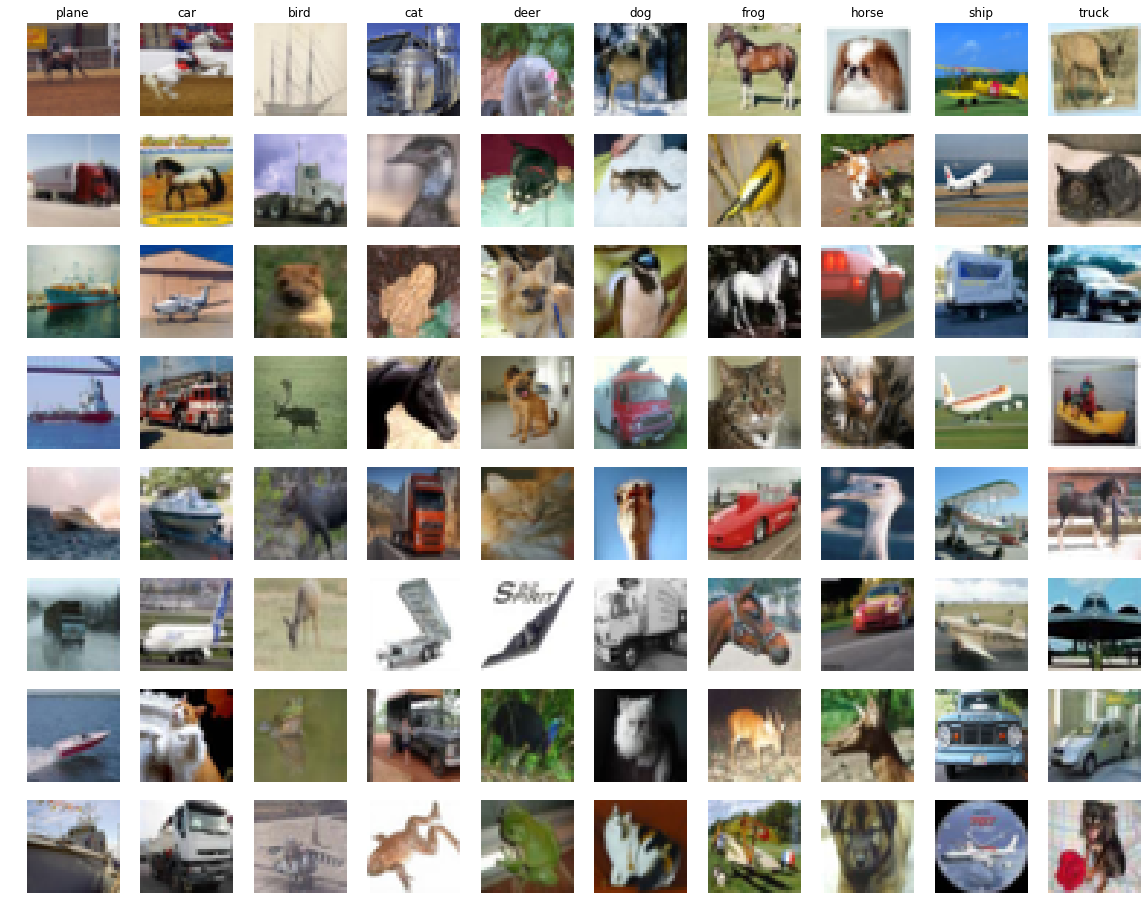

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".
plt.rcParams['figure.figsize'] = (20.0, 16.0)
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Answer: They make sense. For example in plane classification there is a lot of blue and orientation of gradients is similar to planes. This can be generalized to other examples too.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [8]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 750
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
learning_rates=[1e0, 8e-1, 5e-1, 3e-1, 1e-1]
regs=[1e-6, 6e-6, 1e-5, 5e-5, 3e-5, 1e-4, 5e-4, 1e-3, 5e-3]
best_val_acc = -1
best_stats = -1
for learning_rate in learning_rates:
    for reg in regs:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                    num_iters=1000, batch_size=400,
                    learning_rate=learning_rate, learning_rate_decay=0.95,
                    reg=reg, verbose=True)

        # Predict on the validation set
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        print(f"Learning rate:{learning_rate}, reg: {reg} Validation accuracy:{val_acc} ")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_net = net
            best_stats = stats
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.397219
iteration 200 / 1000: loss 1.277265
iteration 300 / 1000: loss 1.210198
iteration 400 / 1000: loss 1.061588
iteration 500 / 1000: loss 1.145942
iteration 600 / 1000: loss 0.995886
iteration 700 / 1000: loss 1.001043
iteration 800 / 1000: loss 0.901557
iteration 900 / 1000: loss 0.869146
Learning rate:1.0, reg: 1e-06 Validation accuracy:0.57 
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.408954
iteration 200 / 1000: loss 1.326374
iteration 300 / 1000: loss 1.169852
iteration 400 / 1000: loss 1.177155
iteration 500 / 1000: loss 1.010504
iteration 600 / 1000: loss 1.038728
iteration 700 / 1000: loss 0.897039
iteration 800 / 1000: loss 0.875316
iteration 900 / 1000: loss 0.801191
Learning rate:1.0, reg: 6e-06 Validation accuracy:0.588 
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.376253
iteration 200 / 1000: loss 1.264675
iteration 300 / 1000: loss 1.170733
iteration 400 / 1000: loss 1.

iteration 900 / 1000: loss 1.016503
Learning rate:0.5, reg: 6e-06 Validation accuracy:0.581 
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.502511
iteration 200 / 1000: loss 1.307492
iteration 300 / 1000: loss 1.310173
iteration 400 / 1000: loss 1.308568
iteration 500 / 1000: loss 1.148370
iteration 600 / 1000: loss 1.104117
iteration 700 / 1000: loss 1.150077
iteration 800 / 1000: loss 1.024279
iteration 900 / 1000: loss 1.005000
Learning rate:0.5, reg: 1e-05 Validation accuracy:0.594 
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.441993
iteration 200 / 1000: loss 1.407109
iteration 300 / 1000: loss 1.328831
iteration 400 / 1000: loss 1.211144
iteration 500 / 1000: loss 1.144101
iteration 600 / 1000: loss 1.171013
iteration 700 / 1000: loss 0.976871
iteration 800 / 1000: loss 0.971223
iteration 900 / 1000: loss 1.038168
Learning rate:0.5, reg: 5e-05 Validation accuracy:0.59 
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.559337
iteratio

iteration 600 / 1000: loss 1.492430
iteration 700 / 1000: loss 1.342524
iteration 800 / 1000: loss 1.277805
iteration 900 / 1000: loss 1.429093
Learning rate:0.1, reg: 5e-05 Validation accuracy:0.514 
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.301543
iteration 200 / 1000: loss 2.100404
iteration 300 / 1000: loss 1.806409
iteration 400 / 1000: loss 1.570434
iteration 500 / 1000: loss 1.460644
iteration 600 / 1000: loss 1.449802
iteration 700 / 1000: loss 1.340282
iteration 800 / 1000: loss 1.408304
iteration 900 / 1000: loss 1.361839
Learning rate:0.1, reg: 3e-05 Validation accuracy:0.519 
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302160
iteration 200 / 1000: loss 2.135586
iteration 300 / 1000: loss 1.779990
iteration 400 / 1000: loss 1.502525
iteration 500 / 1000: loss 1.528550
iteration 600 / 1000: loss 1.496717
iteration 700 / 1000: loss 1.472223
iteration 800 / 1000: loss 1.309109
iteration 900 / 1000: loss 1.364814
Learning rate:0.1, reg: 0.

In [9]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.577


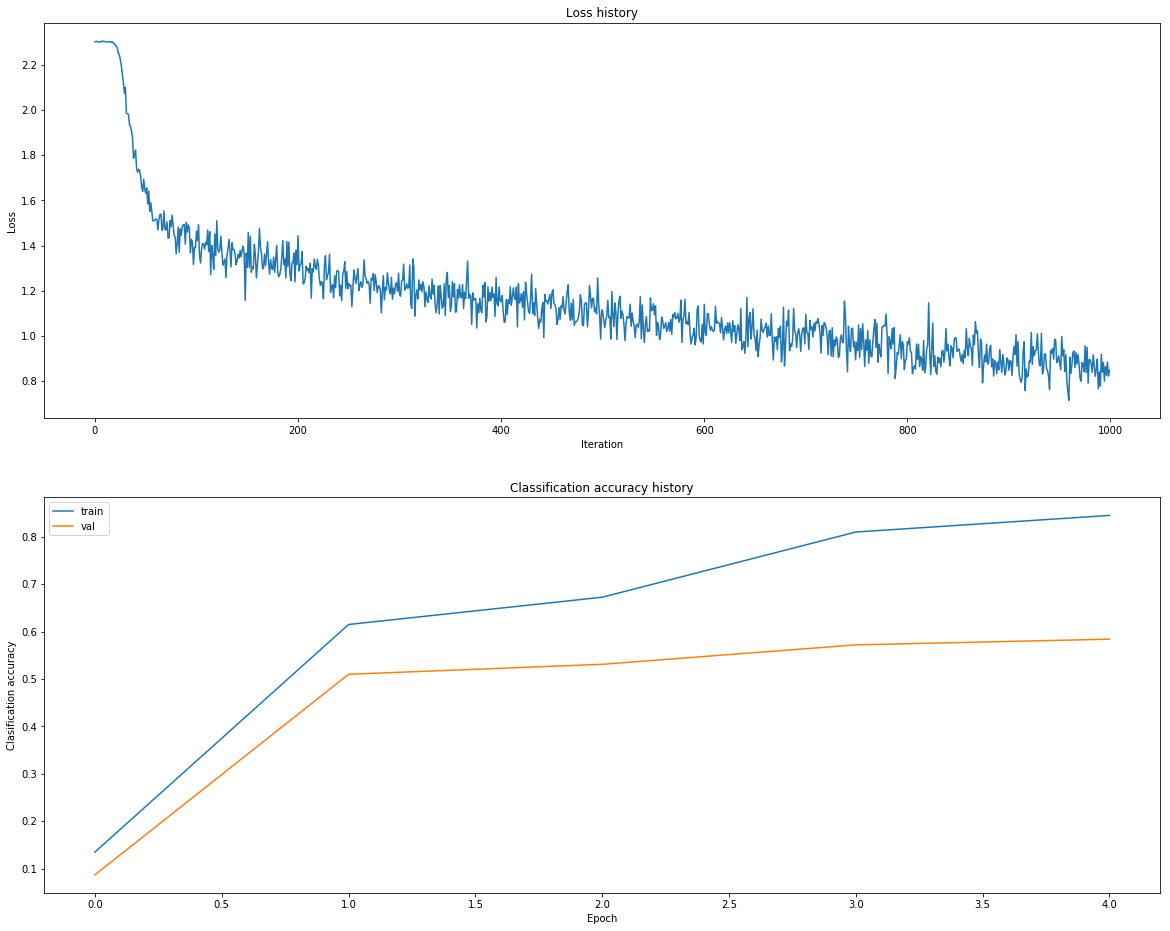

In [10]:
# Plot the loss function and train / validation accuracies
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()